# Looking at our data

## 1. Load data

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

import PIL
import PIL.Image
import cv2 as cv
import scipy.ndimage as ndimage

from tensorflow.keras import models, layers, preprocessing, backend
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.optimizers import Adam, SGD

print('done')

done


## Dehaze function

In [34]:
def get_dark_channel_prior(img, w_size=15):  
    J_dark = ndimage.minimum_filter(img, footprint=np.ones((w_size,w_size,3)), mode='nearest')        
    return J_dark[:,:,1]

def estimate_atmospheric_light(img, w_size=15):
    size = img.shape[:2]
    k = int(0.001*np.prod(size))
    j_dark = get_dark_channel_prior(img, w_size=w_size)
    idx = np.argpartition(-j_dark.ravel(),k)[:k]
    x, y = np.hsplit(np.column_stack(np.unravel_index(idx, size)), 2)
    A = np.array([img[x,y,0].max(), img[x,y,1].max(), img[x,y,2].max()])
    return A

def estimate_transmission(img, omega=0.95, w_size=15):
    A= estimate_atmospheric_light(img)
    norm_img = img / A
    norm_img_dc = get_dark_channel_prior(norm_img, w_size=w_size)
    return 1 - omega*norm_img_dc

def guided_filter(I, p, omega=60, eps=0.01):
    w_size = (omega,omega)
    I = I/255
    I_r, I_g, I_b = I[:,:,0], I[:,:,1], I[:,:,2]
    
    mean_I_r = cv.blur(I_r, w_size)
    mean_I_g = cv.blur(I_g, w_size)
    mean_I_b = cv.blur(I_b, w_size)
    
    mean_p = cv.blur(p, w_size)
    
    mean_Ip_r = cv.blur(I_r*p, w_size)
    mean_Ip_g = cv.blur(I_g*p, w_size)
    mean_Ip_b = cv.blur(I_b*p, w_size)
         
    cov_Ip_r =  mean_Ip_r - mean_I_r*mean_p
    cov_Ip_g =  mean_Ip_g - mean_I_g*mean_p
    cov_Ip_b =  mean_Ip_b - mean_I_b*mean_p
    cov_Ip = np.stack([cov_Ip_r, cov_Ip_g, cov_Ip_b], axis=-1)
    
    var_I_rr = cv.blur(I_r*I_r, w_size) - mean_I_r*mean_I_r
    var_I_rg = cv.blur(I_r*I_g, w_size) - mean_I_r*mean_I_g
    var_I_rb = cv.blur(I_r*I_b, w_size) - mean_I_r*mean_I_b
    var_I_gb = cv.blur(I_g*I_b, w_size) - mean_I_g*mean_I_b
    var_I_gg = cv.blur(I_g*I_g, w_size) - mean_I_g*mean_I_g
    var_I_bb = cv.blur(I_b*I_b, w_size) - mean_I_b*mean_I_b
    
    a = np.zeros(I.shape)
    for x, y in np.ndindex(I.shape[:2]):
        Sigma = np.array([
            [var_I_rr[x,y], var_I_rg[x,y], var_I_rb[x,y]],
            [var_I_rg[x,y], var_I_gg[x,y], var_I_gb[x,y]],
            [var_I_rb[x,y], var_I_gb[x,y], var_I_bb[x,y]]
        ])
        c = cov_Ip[x,y,:]
        
        a[x,y,:] = np.linalg.inv(Sigma + eps*np.eye(3)).dot(c)
        
    mean_a = np.stack([cv.blur(a[:,:,0], w_size), cv.blur(a[:,:,1], w_size), cv.blur(a[:,:,2], w_size)], axis=-1)
    mean_I = np.stack([mean_I_r, mean_I_g, mean_I_b], axis=-1)
    
    b = mean_p - np.sum(a*mean_I, axis=2)
    mean_b = cv.blur(b, w_size)
    q = np.sum(mean_a*I, axis=2) + mean_b
    
    return q

def haze_removal(img, w_size=15, a_omega=0.95, gf_w_size=200, eps=1e-6):
    img = img.astype(np.int16)
    A = estimate_atmospheric_light(img, w_size=w_size)
    alpha_map = estimate_transmission(img, omega=a_omega, w_size=w_size)
    f_alpha_map = guided_filter(img, alpha_map, omega=gf_w_size, eps=eps)
    
    img[:,:,0] -= A[0]
    img[:,:,1] -= A[1]
    img[:,:,2] -= A[2]
    z = np.maximum(f_alpha_map, 0.1)
    img[:,:,0] = img[:,:,0]/z
    img[:,:,1] = img[:,:,1]/z
    img[:,:,2] = img[:,:,2]/z

    img[:,:,0] += A[0]
    img[:,:,1] += A[1]
    img[:,:,2] += A[2]

    img = np.maximum(img, 0)
    img = np.minimum(img, 255)
    
    return img/255

### 1.1 Load classification file

In [3]:
# For loading data from google cloud into colab

project_id = project_id
bucket_name = bucket_name
#from google.colab import auth
#auth.authenticate_user()

In [4]:
#!gsutil cp gs://{bucket_name}/train_classes.csv /tmp/train_classes.csv

Copying gs://brazil_amazon_sat_images/train_classes.csv...
/ [1 files][  1.4 MiB/  1.4 MiB]                                                
Operation completed over 1 objects/1.4 MiB.                                      


In [5]:
#!gsutil cp gs://{bucket_name}/train-jpg.zip /tmp/train-jpg

Copying gs://brazil_amazon_sat_images/train-jpg.zip...
| [1 files][610.6 MiB/610.6 MiB]                                                
Operation completed over 1 objects/610.6 MiB.                                    


In [6]:
train_classes = pd.read_csv(file_path)

In [ ]:
# if image folder is a zip file
#!unzip /tmp/train-jpg

### 1.2. Edit classification data

In [8]:
labels = []
for i in train_classes['tags']:
    for x in i.split(' '):
        if x not in labels:
            labels.append(x)

train_classes['tag_list'] = train_classes['tags'].apply(lambda x: x.split(' '))
train_classes['image_name'] = train_classes['image_name'].apply(lambda x: (x + '.jpg') if '.jpg' not in x else x)

In [9]:
for i in labels:
    train_classes[i] = train_classes['tag_list'].apply(lambda x:1 if i in x else 0)

In [10]:
no_weather_img_index = train_classes[train_classes['clear'] + train_classes['cloudy'] + train_classes['haze'] + train_classes['partly_cloudy'] != 1].index[0]

,image_name,tags,tag_list,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
24448,train_24448.jpg,water,[water],0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
train_classes = train_classes.drop(no_weather_img_index)

In [12]:
# Remove clear tag

count=0
for i in train_classes['tag_list']:
    try:
      i.remove('clear')
    except ValueError:
        pass
print(count)

0


In [13]:
# Remove haze tag

count=0
for i in train_classes['tag_list']:
    try:
      i.remove('haze')
    except ValueError:
      count+=1
print(count)

37781


### 1.3. Make train and test data

In [14]:
train=train_classes.sample(frac=0.7,random_state=1)
test=train_classes.drop(train.index)

In [42]:
datagen=preprocessing.image.ImageDataGenerator(rescale=1./255, shear_range=0.2,
            horizontal_flip=True, vertical_flip=True, validation_split=0.25)
train_gen=datagen.flow_from_dataframe(dataframe=train, 
                                directory="train-jpg", x_col="image_name", y_col="tag_list", subset="training", seed=42,
                                shuffle=True, class_mode="categorical", target_size=(128,128), batch_size=32)
valid_gen=datagen.flow_from_dataframe(dataframe=train, 
                                directory="train-jpg", x_col="image_name", y_col="tag_list", subset="validation", seed=42,
                                shuffle=True, class_mode="categorical", target_size=(128,128), batch_size=32)


Found 21252 validated image filenames belonging to 15 classes.
Found 7083 validated image filenames belonging to 15 classes.


In [43]:
datagen_test=preprocessing.image.ImageDataGenerator(rescale=1./255)
test_gen=datagen_test.flow_from_dataframe(dataframe=test, 
                                directory="train-jpg", x_col="image_name", y_col="tag_list",
                                class_mode="categorical", target_size=(128,128), batch_size=32)

Found 12143 validated image filenames belonging to 15 classes.


In [18]:
print(train_gen.n)
print(train_gen.batch_size)

21252
32


### 1.4. Make model

In [20]:
# calculate fbeta score for multi-class/label classification
def fbeta_round(y_true, y_pred, beta_sq=4):
	# clip predictions
	y_pred = backend.clip(y_pred, 0, 1)
	# calculate elements
	tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
	fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
	fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
	# calculate precision
	precision = tp / (tp + fp + backend.epsilon())
	# calculate recall
	recall = tp / (tp + fn + backend.epsilon())
	# calculate fbeta, averaged across each class
	fbeta_score = backend.mean((1 + beta_sq) * (precision * recall) / (beta_sq * precision + recall + backend.epsilon()))
	return fbeta_score

In [21]:
def fbeta(y_true, y_pred):
    beta_squared = (1.5)**2

    tp = backend.sum(y_true * y_pred) + backend.epsilon()
    fp = backend.sum(y_pred) - tp
    fn = backend.sum(y_true) - tp

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    result = (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + backend.epsilon())

    return result

def f2(y_true, y_pred):
    beta_squared = 4

    tp = backend.sum(y_true * y_pred) + backend.epsilon()
    fp = backend.sum(y_pred) - tp
    fn = backend.sum(y_true) - tp

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    result = (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + backend.epsilon())

    return result

In [22]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(128,128,3), pooling='avg')

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output

# add fully-connected layer
x = layers.Dense(2048, activation='relu')(x)

# add dropout
x = layers.Dropout(0.25)(x)

# add logistic layer
predictions = layers.Dense(15, activation='sigmoid')(x)

# this is the model we will train
model = models.Model(inputs=base_model.input, outputs=predictions)

optimizer = Adam(0.001, decay=0.0003)

callbacks = [ModelCheckpoint('best_weights.hdf5', monitor='val_loss', save_best_only=True, verbose=2, save_weights_only=False),
             ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.0000001),
             EarlyStopping(monitor='val_loss', patience=5, verbose=0)]

94773248/94765736 [==============================] - 0s 0us/step


In [23]:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[fbeta, f2, fbeta_round, 'accuracy'])

In [ ]:
model.summary()

In [44]:
STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=valid_gen.n//valid_gen.batch_size
STEP_SIZE_TEST=test_gen.n//test_gen.batch_size
history = model.fit_generator(generator=train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_gen,
                    validation_steps=STEP_SIZE_VALID,
                    callbacks=callbacks,
                    epochs=1)

664/664 [==============================] - ETA: 0s - loss: 0.2292 - fbeta: 0.5220 - f2: 0.5228 - fbeta_round: 0.6079 - accuracy: 0.4536
Epoch 00001: val_loss improved from inf to 0.22334, saving model to best_weights.hdf5
664/664 [==============================] - 163s 245ms/step - loss: 0.2292 - fbeta: 0.5220 - f2: 0.5228 - fbeta_round: 0.6079 - accuracy: 0.4536 - val_loss: 0.2233 - val_fbeta: 0.5205 - val_f2: 0.5178 - val_fbeta_round: 0.6134 - val_accuracy: 0.4536


In [46]:
optimizer = Adam(0.0001, decay=0.00000001)
model.load_weights('best_weights.hdf5', by_name=True)
for layer in base_model.layers:
    layer.trainable = True

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', fbeta, f2, fbeta_round])
history1 = model.fit_generator(generator=train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_gen,
                    validation_steps=STEP_SIZE_VALID,
                    callbacks=callbacks,
                    epochs=50)

Epoch 1/50
664/664 [==============================] - ETA: 0s - loss: 0.1414 - accuracy: 0.5213 - fbeta: 0.7533 - f2: 0.7553 - fbeta_round: 0.8297
Epoch 00001: val_loss did not improve from 0.22334
664/664 [==============================] - 179s 270ms/step - loss: 0.1414 - accuracy: 0.5213 - fbeta: 0.7533 - f2: 0.7553 - fbeta_round: 0.8297 - val_loss: 0.3675 - val_accuracy: 0.0082 - val_fbeta: 0.3069 - val_f2: 0.3058 - val_fbeta_round: 0.1094
Epoch 2/50
664/664 [==============================] - ETA: 0s - loss: 0.0977 - accuracy: 0.5391 - fbeta: 0.8043 - f2: 0.8050 - fbeta_round: 0.8712
Epoch 00002: val_loss improved from 0.22334 to 0.10951, saving model to best_weights.hdf5
664/664 [==============================] - 178s 269ms/step - loss: 0.0977 - accuracy: 0.5391 - fbeta: 0.8043 - f2: 0.8050 - fbeta_round: 0.8712 - val_loss: 0.1095 - val_accuracy: 0.5095 - val_fbeta: 0.8007 - val_f2: 0.8054 - val_fbeta_round: 0.8558
Epoch 3/50
664/664 [==============================] - ETA: 0s - los

In [49]:
# plot diagnostic learning curves
def summarize_diagnostics(model_history):
  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,4))
	# plot loss
  ax1.set_title('Cross Entropy Loss')
  ax1.plot(model_history.history['loss'], color='blue', label='train')
  ax1.plot(model_history.history['val_loss'], color='orange', label='test')
	# plot accuracy
  ax2.set_title('f2')
  ax2.plot(model_history.history['f2'], color='blue', label='train')
  ax2.plot(model_history.history['val_f2'], color='orange', label='test')

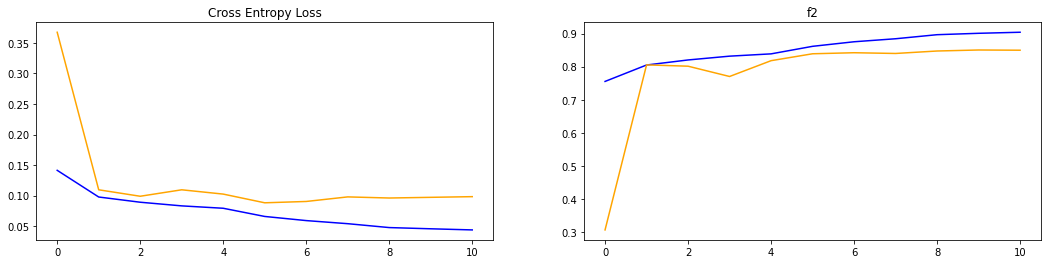

In [50]:
summarize_diagnostics(history1)

In [51]:
model.evaluate_generator(test_gen, steps=STEP_SIZE_TEST, verbose=1)

Instructions for updating:
Please use Model.evaluate, which supports generators.
379/379 [==============================] - 28s 74ms/step - loss: 0.0989 - accuracy: 0.5543 - fbeta: 0.8494 - f2: 0.8481 - fbeta_round: 0.8937


[0.09893188625574112,
 0.5543370842933655,
 0.8493970632553101,
 0.8481264114379883,
 0.8937033414840698]

In [52]:
model.save('GreenEyeResNet50V1')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: greeneye-resnet50/assets


In [53]:
# Zip model folder into file for downloading from colab

#!zip -r greeneye-resnet50.zip greeneye-resnet50/

  adding: greeneye-resnet50/ (stored 0%)
  adding: greeneye-resnet50/saved_model.pb (deflated 93%)
  adding: greeneye-resnet50/assets/ (stored 0%)
  adding: greeneye-resnet50/variables/ (stored 0%)
  adding: greeneye-resnet50/variables/variables.index (deflated 81%)
  adding: greeneye-resnet50/variables/variables.data-00000-of-00001 (deflated 8%)


### 1.5. Make a Prediction

In [37]:
# Load batch of test images and select the first from batch

img_label_batch = next(iter(test_gen))
label=img_label_batch[1][0]
img=img_label_batch[0][0]

In [38]:
# Make prediction and compare with labels

print(model.predict(img_label_batch[0])[0])
print(label)

[0.26237807 0.00350679 0.01793735 0.00431442 0.00266427 0.0642231
 0.00248608 0.1478302  0.08135573 0.16150424 0.909594   0.1507984
 0.01303976 0.00350005 0.16392027]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


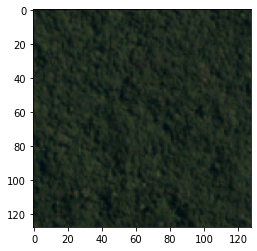

In [40]:
# Inspect image

plt.imshow(img)

## 3. Explore data

In [ ]:
def conditional_frequency(a, b):
    v = (a * b).sum()/b.sum()
    return v
train_classes.drop(weather, axis=1).corr(method=conditional_frequency)

,primary,agriculture,water,habitation,road,cultivation,slash_burn,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
primary,1.000000,0.972148,0.944677,0.947814,0.957502,0.995086,1.000000,0.940000,0.792343,0.955752,1.000000,1.000000,1.000000
agriculture,0.972148,1.000000,0.365943,0.747814,0.747615,0.754300,0.569378,0.240000,0.261021,0.112094,0.096386,0.191176,0.224490
water,0.944677,0.365943,1.000000,0.250000,0.263288,0.193880,0.114833,0.260000,0.238979,0.882006,0.048193,0.144118,0.030612
habitation,0.947814,0.747814,0.250000,1.000000,0.345186,0.199911,0.196172,0.360000,0.189095,0.085546,0.012048,0.038235,0.030612
road,0.957502,0.747615,0.263288,0.345186,1.000000,0.289033,0.172249,0.590000,0.374710,0.324484,0.030120,0.444118,0.020408
cultivation,0.995086,0.754300,0.193880,0.199911,0.289033,1.000000,0.602871,0.040000,0.103248,0.053097,0.105422,0.170588,0.081633
slash_burn,1.000000,0.569378,0.114833,0.196172,0.172249,0.602871,1.000000,0.000000,0.011601,0.000000,0.006024,0.005882,0.020408
conventional_mine,0.940000,0.240000,0.260000,0.360000,0.590000,0.040000,0.000000,1.000000,0.011601,0.011799,0.000000,0.000000,0.000000
bare_ground,0.792343,0.261021,0.238979,0.189095,0.374710,0.103248,0.011601,0.011601,1.000000,0.117994,0.009036,0.038235,0.040816
artisinal_mine,0.955752,0.112094,0.882006,0.085546,0.324484,0.053097,0.000000,0.011799,0.117994,1.000000,0.000000,0.017647,0.000000


In [ ]:
features = ['agriculture', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 
            'conventional_mine', 'bare_ground', 'artisinal_mine',
       'blooming', 'selective_logging', 'blow_down']

In [ ]:
train_classes[train_classes[features].sum(axis = 1) == 1].sum()

image_name           train_5.jpgtrain_11.jpgtrain_24.jpgtrain_30.jp...
tags                 [haze, primary, water, clear, primary, water, ...
haze                                                               594
primary                                                           6923
agriculture                                                       2554
clear                                                             5208
water                                                             3050
habitation                                                          52
road                                                               379
cultivation                                                        558
slash_burn                                                          13
cloudy                                                               0
partly_cloudy                                                     1560
conventional_mine                                                   26
bare_g

In [ ]:
train_classes.sum()

image_name           train_0.jpgtrain_1.jpgtrain_2.jpgtrain_3.jpgtr...
tags                 [haze, primary, agriculture, clear, primary, w...
haze                                                              2697
primary                                                          37513
agriculture                                                      12315
clear                                                            28431
water                                                             7411
habitation                                                        3660
road                                                              8071
cultivation                                                       4477
slash_burn                                                         209
cloudy                                                            2089
partly_cloudy                                                     7261
conventional_mine                                                  100
bare_g

In [ ]:
train_classes[train_classes['primary']==0].mean(axis=0)

haze                 0.009103
primary              0.000000
agriculture          0.115644
clear                0.257249
water                0.138233
habitation           0.064396
road                 0.115644
cultivation          0.007417
slash_burn           0.000000
cloudy               0.704316
partly_cloudy        0.028995
conventional_mine    0.002023
bare_ground          0.060351
artisinal_mine       0.005057
blooming             0.000000
selective_logging    0.000000
blow_down            0.000000
dtype: float64

In [ ]:
train_classes[train_classes['artisinal_mine']==1].mean(axis=0)

primary              0.955752
agriculture          0.112094
water                0.882006
habitation           0.085546
road                 0.324484
cultivation          0.053097
slash_burn           0.000000
conventional_mine    0.011799
bare_ground          0.117994
artisinal_mine       1.000000
blooming             0.000000
selective_logging    0.017699
blow_down            0.000000
clear                0.905605
haze                 0.014749
cloudy               0.000000
partly_cloudy        0.079646
dtype: float64

In [ ]:
train_classes[train_classes['blooming']==1].mean(axis=0)

primary              1.000000
agriculture          0.096386
water                0.048193
habitation           0.012048
road                 0.030120
cultivation          0.105422
slash_burn           0.006024
conventional_mine    0.000000
bare_ground          0.009036
artisinal_mine       0.000000
blooming             1.000000
selective_logging    0.021084
blow_down            0.003012
clear                0.936747
haze                 0.012048
cloudy               0.000000
partly_cloudy        0.051205
dtype: float64